In [29]:
%load_ext autoreload
%autoreload 2
#---------------------------Imports-------------------------------------------
import numpy as np
import pandas as pd
import os
import glob
import importlib
import matplotlib.pyplot as plt

import sys

# Add Help_functions directory to the system path - Kommer bli en del sånt nu framöver
sys.path.append(os.path.join(os.getcwd(), 'Help_functions'))


import sympy as sp

from Data_Cleaning_test import*


#----------------------------load_data delete ()-----------------------------------
folder_path = 'C:\\Users\\Master_Student\\ml\\Data\\data_oct_2023\\features\\'
df = import_and_combine_data(folder_path)
# Delete all parentheses in column names, this for PySRRegressor to work
df.columns = df.columns.str.replace(r'\(.*?\)', '', regex=True).str.strip()
#print(df.columns)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
def convert_temperatures_to_kelvin(m_average_data, temp_columns):
    """
    Convert multiple temperature columns in all DataFrames of m_average_data to Kelvin.

    Parameters:
    - m_average_data: Nested dictionary {round_number: {device: DataFrame}}
    - temp_columns: List of temperature column names to convert (e.g., ['min_temperature', 'max_temperature'])
    """
    for round_num, devices in m_average_data.items():  # Loop through rounds
        for device_num, df in devices.items():  # Loop through devices and their DataFrames
            for temp_column in temp_columns:  # Loop through each temperature column
                if temp_column in df.columns:
                    df[temp_column] += 273.15  # Convert to Kelvin
                else:
                    print(f"    Warning: Column '{temp_column}' not found in DataFrame for round {round_num}, device {device_num}.")


In [31]:
#---------------------------Fix Missing data-------------------------------------------
def fix_missing_data(group):
    # Interpolate
    group = group.interpolate(method='linear')
    # Forward fill
    group = group.ffill()
    # Backward fill
    group = group.bfill()
    return group

# Apply all operations in a single pass
grouped = df.groupby(['round', 'device'], group_keys=False)
df = grouped.apply(fix_missing_data)

df['swing_temperature'] = df['max_temperature'] - df['min_temperature'] 

#-----------------------------Abbrevations for plotting---------------------------------------------

temperature_columns = [
    'min_temperature', 
    'max_temperature', 
    'min_block_temperature_1', 
    'max_block_temperature_1', 
    'min_block_temperature_2', 
    'max_block_temperature_2', 
    'avg_max_block_temperature', 
    'min_water_inlet_temperature',
    'max_water_inlet_temperature', 
    'min_water_outlet_temperature', 
    'max_water_outlet_temperature', 
]
# Create the abbreviation dictionary for renaming the columns
abbreviations = {
    'cycle': 'Cyc',
    'consumed_life': 'CL',
    'end_voltage': 'V_end',
    'end_resistance': 'R_end',
    'end_resistance_residual': 'R_res',
    'end_resistance_residual_cleaned': 'R_res_cl',
    'min_temperature': 'T_min',
    'max_temperature': 'T_max',
    'min_block_temperature_1': 'T_B1_min',
    'max_block_temperature_1': 'T_B1_max',
    'min_block_temperature_2': 'T_B2_min',
    'max_block_temperature_2': 'T_B2_max',
    'avg_max_block_temperature': 'T_B_avg_max',
    'min_water_inlet_temperature': 'T_WI_min',
    'max_water_inlet_temperature': 'T_WI_max',
    'min_water_outlet_temperature': 'T_WO_min',
    'max_water_outlet_temperature': 'T_WO_max',
    'swing_temperature': 'T_Sw'
} 

columns_to_clean = ['end_voltage', 'end_resistance',
       'end_resistance_residual', 'end_resistance_residual_cleaned',
       'min_temperature', 'max_temperature', 'min_block_temperature_1',
       'max_block_temperature_1', 'min_block_temperature_2',
       'max_block_temperature_2', 'avg_max_block_temperature',
       'min_water_inlet_temperature', 'max_water_inlet_temperature',
       'min_water_outlet_temperature', 'max_water_outlet_temperature', 'swing_temperature'] # tar bort cycle!

# Function to replace column names with abbreviations
def get_abbreviation(column_name):
    return abbreviations.get(column_name, column_name)  # Use the abbreviation if it exists, otherwise use the original name



#---------------------------------------Get rid of unphyiscal temperature drops in the data---------------------------------------------------------------

#-----------------------------------------------Filtrera datan-----------------------------------------------------

# Rätta till device 1 in round 9
df = df[~((df['round'] == 9) & (df['device'] == 1) & (df['consumed_life'] > 0.985))]
# Filter data for device 1 in round 9
condition = (df['round'] == 9) & (df['device'] == 1)

# Calculate the new 'consumed_life' as the normalized 'cycle' for the remaining rows
df.loc[condition, 'consumed_life'] = (
    df.loc[condition, 'cycle'] / df.loc[condition, 'cycle'].max()
    
#--------------------------------------------------------------------------------    
)
devices = list(range(1,11)) # ska vara 11 här !
rounds = [8, 9]

segmented_data = make_segments(
    df=df,
    devices=devices,
    rounds=rounds,
    cut_at_CL_one=True,       # Remove rows with consumed_life > 1      # Minimum segment size to keep
    cycle_threshold=2000       # Remove rows with cycle < 500
)


filtered_data = exclude_transition_cycles(
    segmented_data=segmented_data, 
    transition_margin=100,  # Standard transition margin 75 förr
    filter_columns=columns_to_clean,
    verbose=True
)

merged_data, aligned_data = merge_segments(
    segmented_data=filtered_data,
    devices=devices,
    rounds=[8, 9],
    columns_to_merge= columns_to_clean,
    mean_interval_proportion=0.1, # 0.1
    min_interval=10,
    max_interval=500,
    transition_margin=10
)

#print(adjusted_segmented_data)
filled_merged_data, gap_statistics = fill_gaps(
   merged_data=merged_data,
   columns_to_fill=columns_to_clean,
    window_size= 1000
)

window_size = 250  

m_average_data = calculate_moving_averages(filled_merged_data, window_size)

convert_temperatures_to_kelvin(m_average_data, temperature_columns)

#convert_voltage_to_millivolts(m_average_data)

#--------------------------------------------Stratified sampling---------------------------------------------------------------------
with_initial_values = add_initial_values(m_average_data, verbose = True)

sampled_data_dict = systematic_sample_device_data(data_dict =with_initial_values, rounds = rounds, devices = devices, n_samples=300, verbose =True)

round_dict_un_sampled = devices_combined_into_one_df(with_initial_values , [8,9]) 
round_dict = devices_combined_into_one_df(sampled_data_dict , [8,9]) #--------------- bra

combined_df_unsampled = combine_all_rounds(round_dict_un_sampled)
combined_df = combine_all_rounds(round_dict)


# Add the 'current' column directly
#combined_df['current'] = 25  # Set default to 25
#combined_df.loc[combined_df['round'] == 9, 'current'] = 22  # Update for round 9



# ta bort device 1 in round 9
#combined_df = combined_df[~((combined_df['round'] == 9) & (combined_df['device'] == 1))]

C:\Users\Master_Student\AppData\Local\Temp\ipykernel_19728\32597329.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = grouped.apply(fix_missing_data)


segment_devices_data:
Total rows removed: 66231.00 out of 1053366.00 (6.29%)
Rows removed due to consumed_life > 1: 26251.00
Rows removed due to cycle < 2000.00: 39980.00
----------------------------------------------------------------------------
exclude_transition_cycles:
Total rows marked as NaN: 24227.00 out of 987135.00 (2.45%)
Total individual NaN values marked: 387632.00
----------------------------------------------------------------------------
fill_gaps:
Total NaN values filled: 387,632 out of 15,794,160 values (2.45%)
Gap Statistics: Max=343.00, Min=102.00, Mean=212.52, Std=39.52, Total Gaps=1824.00
----------------------------------------------------------------------------
calculate_moving_averages
Total rows removed: 4980 out of 987135 (0.50%)
Expected rows removed due to window size (250): 4980.00
--------------------------------------------------------------------------------------------

Processing Round 8
------------------------------------------------------------

D

In [48]:
import pickle

# Specify the paths to the pickle files
pickle_file_path = r"c:\Users\Master_Student\ml\Models_for_images\V_vs_CL_2.pkl"

# Load the models into separate variables
with open(pickle_file_path, "rb") as f:
    model = pickle.load(f)
# Confirm the models are loaded
print("Model loaded successfully!")
print(model)

# Add SymPy mappings using set_params
model.set_params(
    extra_sympy_mappings={
        "pow_4": lambda x: x**4,  # Replace 'pow_4' with x^4
    }
)

# Refresh the model to apply the new mappings
model.refresh()

Model loaded successfully!
PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                                V_0   
	1        0.388378                                 V_0 - -0.042798817   
	2        0.356938                             V_0 + (CL / 11.783216)   
	3        0.078675                      V_0 + (square(CL) / 9.048021)   
	4  >>>>  0.178782                  V_0 + (0.099512786 * (CL - CL_0))   
	5        0.090359            V_0 + square(CL * (CL_0 + -0.40724447))   
	6        0.060830        V_0 + (CL / ((CL_0 * 80.71806) + 6.639025))   
	7        0.062683  (square(CL) / (5.328127 + (CL_0 * 57.347534)))...   
	8        0.115654  V_0 + ((CL - (CL_0 / (V_0 + -1.2194061))) / 7....   
	
	       loss  complexity  
	0  0.003391           1  
	1  0.001560           3  
	2  0.000764           5  
	3  0.000706           6  
	4  0.000590           7  
	5  0.000539           8  
	6  0.000508           

In [49]:
print(model)

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                                V_0   
	1        0.388378                                 V_0 - -0.042798817   
	2        0.356938                             V_0 + (CL / 11.783216)   
	3        0.078675                      V_0 + (square(CL) / 9.048021)   
	4  >>>>  0.178782                  V_0 + (0.099512786 * (CL - CL_0))   
	5        0.090359            V_0 + square(CL * (CL_0 + -0.40724447))   
	6        0.060830        V_0 + (CL / ((CL_0 * 80.71806) + 6.639025))   
	7        0.062683  (square(CL) / (5.328127 + (CL_0 * 57.347534)))...   
	8        0.115654  V_0 + ((CL - (CL_0 / (V_0 + -1.2194061))) / 7....   
	
	       loss  complexity  
	0  0.003391           1  
	1  0.001560           3  
	2  0.000764           5  
	3  0.000706           6  
	4  0.000590           7  
	5  0.000539           8  
	6  0.000508           9  
	7  0.000477          1

In [50]:
print(model.equations['equation'])

equations = model.equations['equation']


for i, eq in enumerate(equations):
    print(f"Equation {i}:")
    print(eq)
    print("-" * 50)  # Separator for better readability

c:\Users\Master_Student\ml\my_env\Lib\site-packages\pysr\sr.py:1172: FutureWarning: PySRRegressor.equations is now deprecated. Please use PySRRegressor.equations_ instead.
  warnings.warn(


0                                                  V_0
1                                   V_0 - -0.042798817
2                               V_0 + (CL / 11.783216)
3                        V_0 + (square(CL) / 9.048021)
4                    V_0 + (0.099512786 * (CL - CL_0))
5              V_0 + square(CL * (CL_0 + -0.40724447))
6          V_0 + (CL / ((CL_0 * 80.71806) + 6.639025))
7    (square(CL) / (5.328127 + (CL_0 * 57.347534)))...
8    V_0 + ((CL - (CL_0 / (V_0 + -1.2194061))) / 7....
Name: equation, dtype: object
Equation 0:
V_0
--------------------------------------------------
Equation 1:
V_0 - -0.042798817
--------------------------------------------------
Equation 2:
V_0 + (CL / 11.783216)
--------------------------------------------------
Equation 3:
V_0 + (square(CL) / 9.048021)
--------------------------------------------------
Equation 4:
V_0 + (0.099512786 * (CL - CL_0))
--------------------------------------------------
Equation 5:
V_0 + square(CL * (CL_0 + -0.40724447)

In [51]:
# Prepare the data for all rounds
X = combined_df_unsampled[['consumed_life', 'init_consumed_life', 'init_end_voltage', 'round', 'device']].rename(
    columns={'consumed_life': 'CL', 'init_consumed_life': 'CL_0', 'init_end_voltage': 'V_0'}
)
y = combined_df_unsampled['end_voltage']

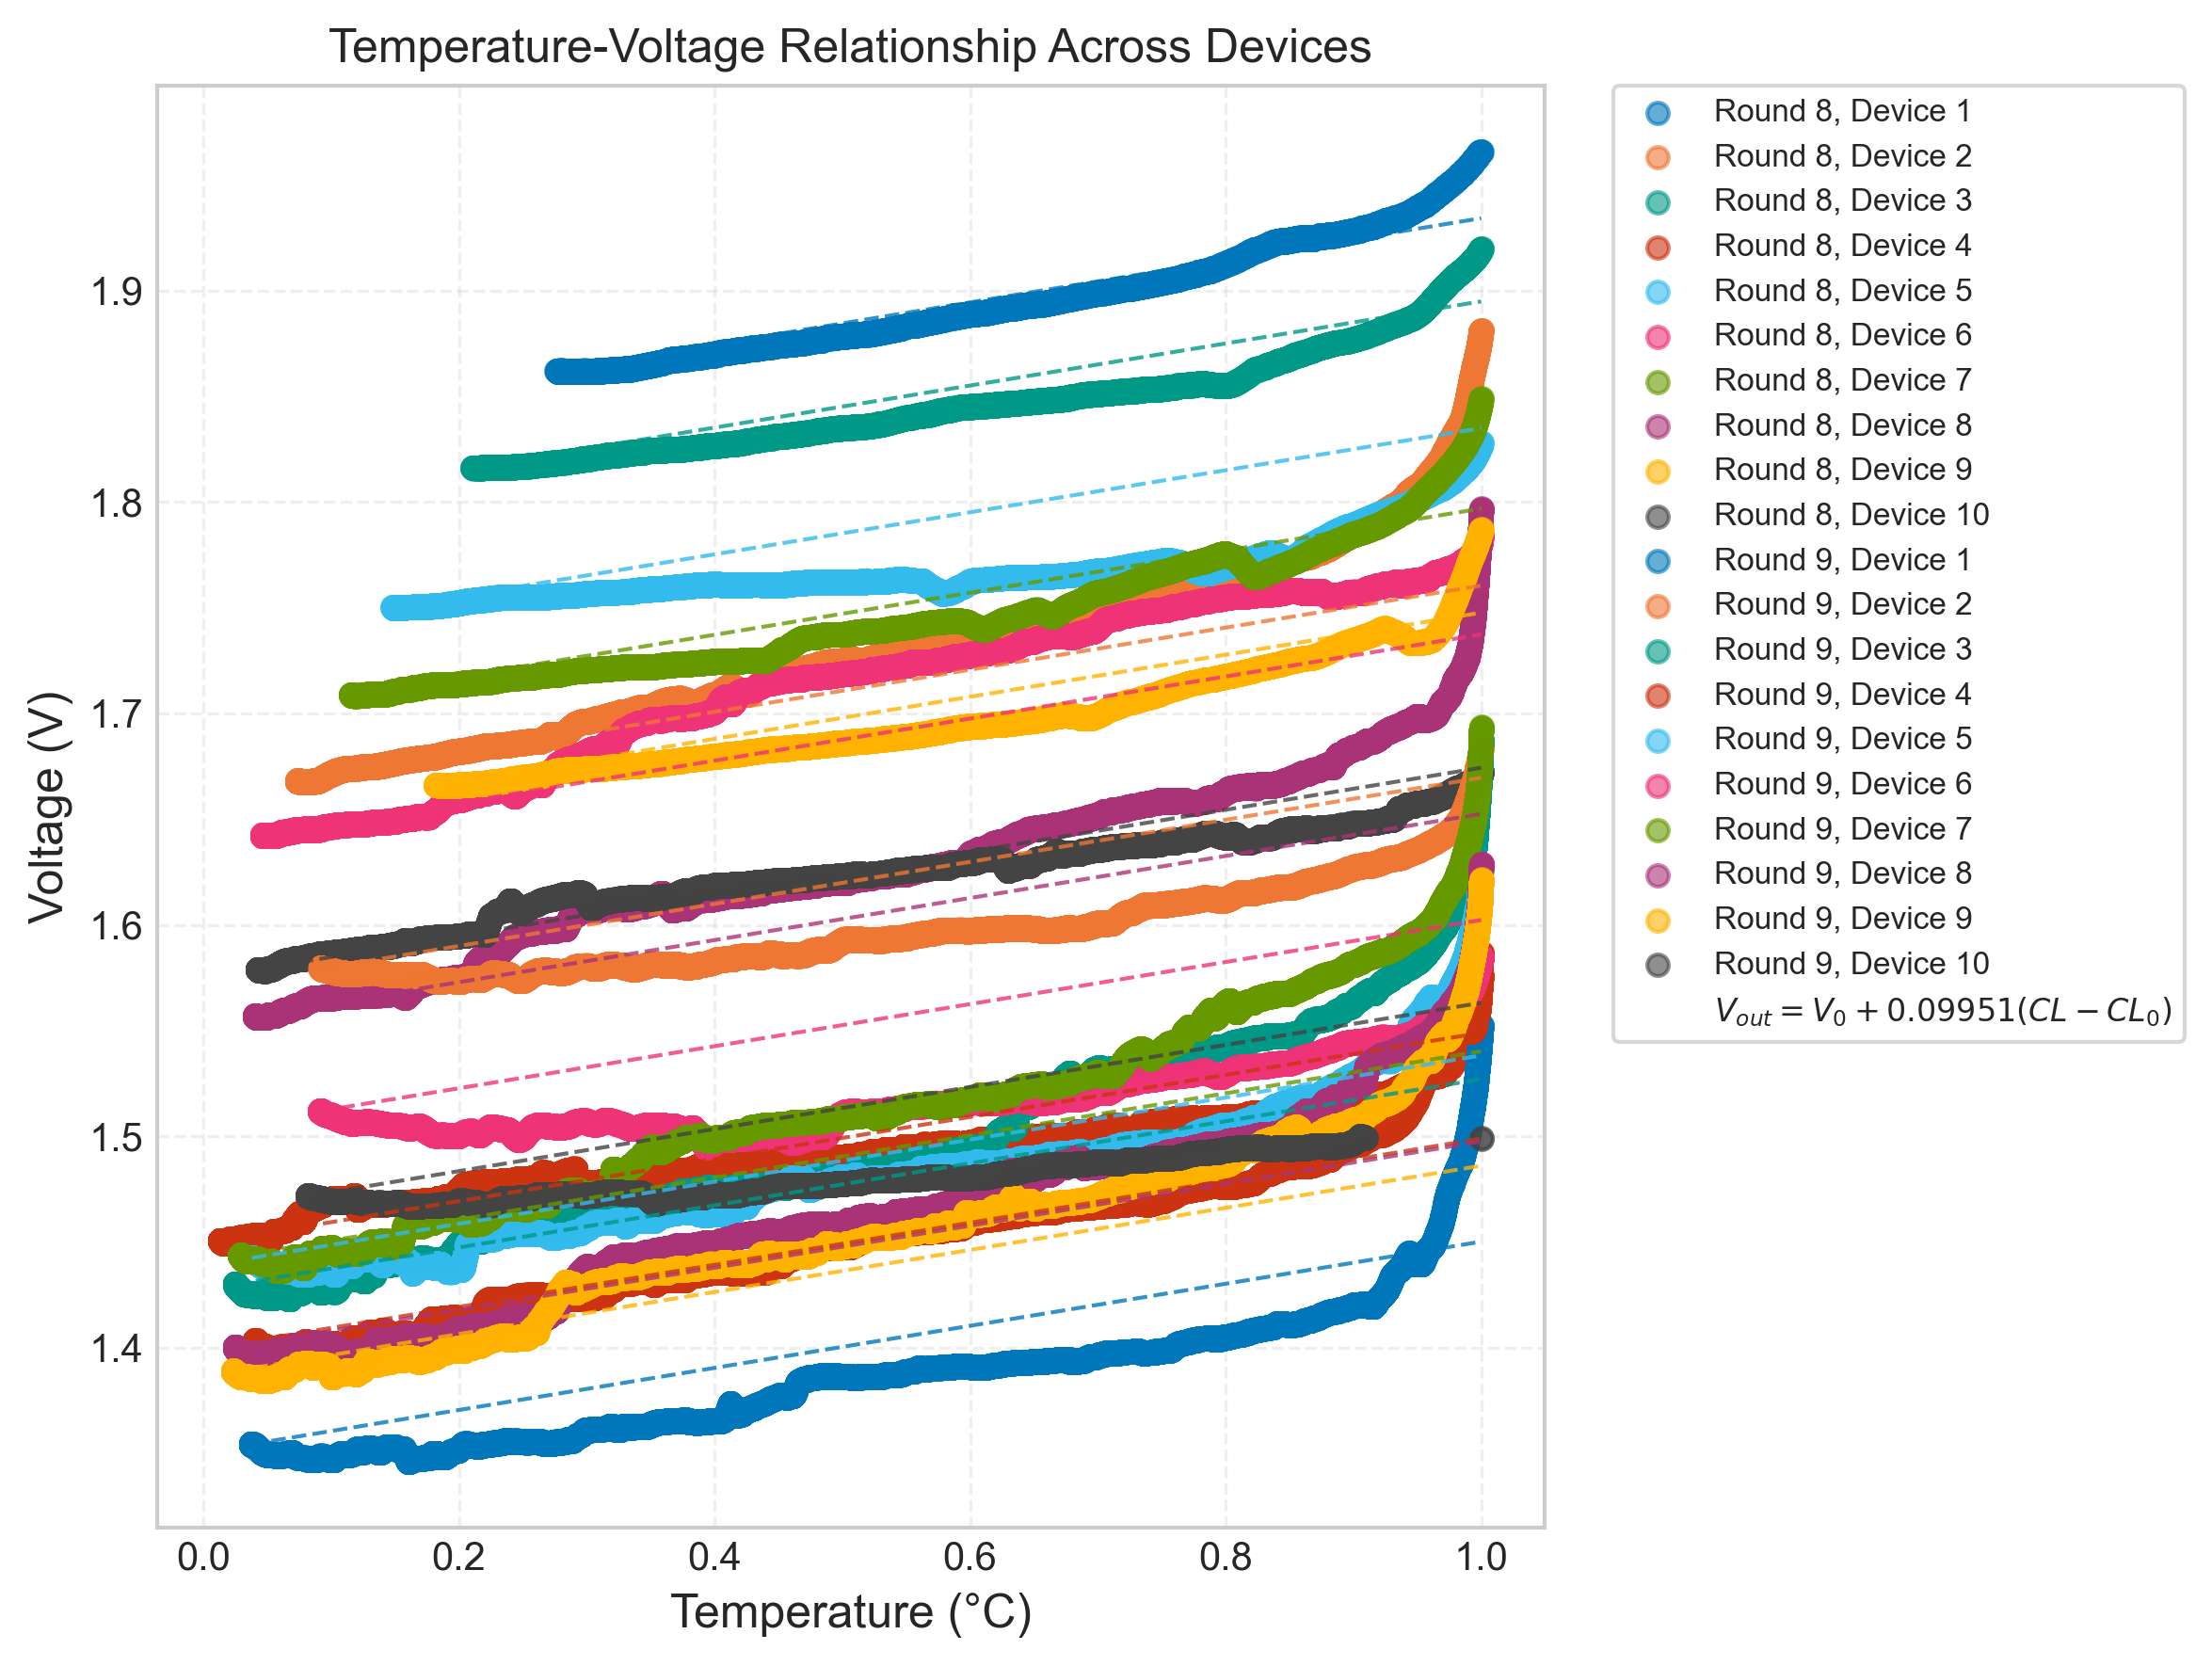

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

def plot_combined_regression_comparison(X, y, model, eq_index=0, save_path=None):
    """
    Create publication-quality plot of temperature vs voltage data with predictions.
    
    Parameters:
    - X: DataFrame with features ('T', 'T_0', 'V_0')
    - y: Series with voltage data
    - model: PySR model for predictions
    - eq_index: Index of equation for LaTeX representation
    - save_path: Optional path to save figure
    """
    # Set publication-quality style parameters
    plt.style.use('seaborn-v0_8-whitegrid')
    mpl.rcParams.update({
        'font.family': 'Arial',
        'font.size': 10,
        'axes.labelsize': 12,
        'axes.titlesize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 8,
        'figure.dpi': 300
    })

    
    # Create figure with appropriate dimensions for publication
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Professional color scheme
    colors = ['#0077BB', '#EE7733', '#009988', '#CC3311', '#33BBEE',
              '#EE3377', '#669900', '#AA3377', '#FFB300', '#444444']
    
    # Generate predictions
    y_pred = model.predict(X, eq_index)
    
    for round_number in [8, 9]:
        round_mask = (X['round'] == round_number)
        X_round = X[round_mask]
        y_round = y[round_mask]
        y_pred_round = y_pred[round_mask]
        
        for device_num in range(1, 11):
            device_mask = (X_round['device'] == device_num)
            
            if not device_mask.any():
                continue
            
            device_data = pd.DataFrame({
                'CL': X_round.loc[device_mask, 'CL'],
                'V': y_round[device_mask],
                'predicted_voltage': y_pred_round[device_mask]
            }).sort_values('CL')
            
            # Plot with professional styling
            ax.scatter(device_data['CL'], device_data['V'],
                      color=colors[device_num-1], alpha=0.6, s=30,
                      label=f'Round {round_number}, Device {device_num}')
            
            ax.plot(device_data['CL'], device_data['predicted_voltage'],
                   linestyle='--', color=colors[device_num-1], alpha=0.8,
                   linewidth=1)

    # Add equation with professional formatting
    expr_latex = model.latex(eq_index, 4)
    ax.plot([], [], ' ', label=f'$V_{{out}} = {expr_latex}$')
    
    # Customize axes and labels
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('Voltage (V)')
    ax.set_title('Temperature-Voltage Relationship Across Devices')
    
    # Improve grid appearance
    ax.grid(True, linestyle='--', alpha=0.3, which='major')
    ax.grid(True, linestyle=':', alpha=0.1, which='minor')
    
    # Format legend professionally
    legend = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
                      borderaxespad=0., ncol=1, frameon=True)
    legend.get_frame().set_alpha(0.9)
    legend.get_frame().set_edgecolor('lightgray')
    
    # Adjust layout to prevent cutoff
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    return fig, ax

fig, ax = plot_combined_regression_comparison(X, y, model, eq_index=4, save_path='regression_plot.png')

Average MSEs for each round: [np.float64(0.000488947711108817), np.float64(0.0004207646822634597)]


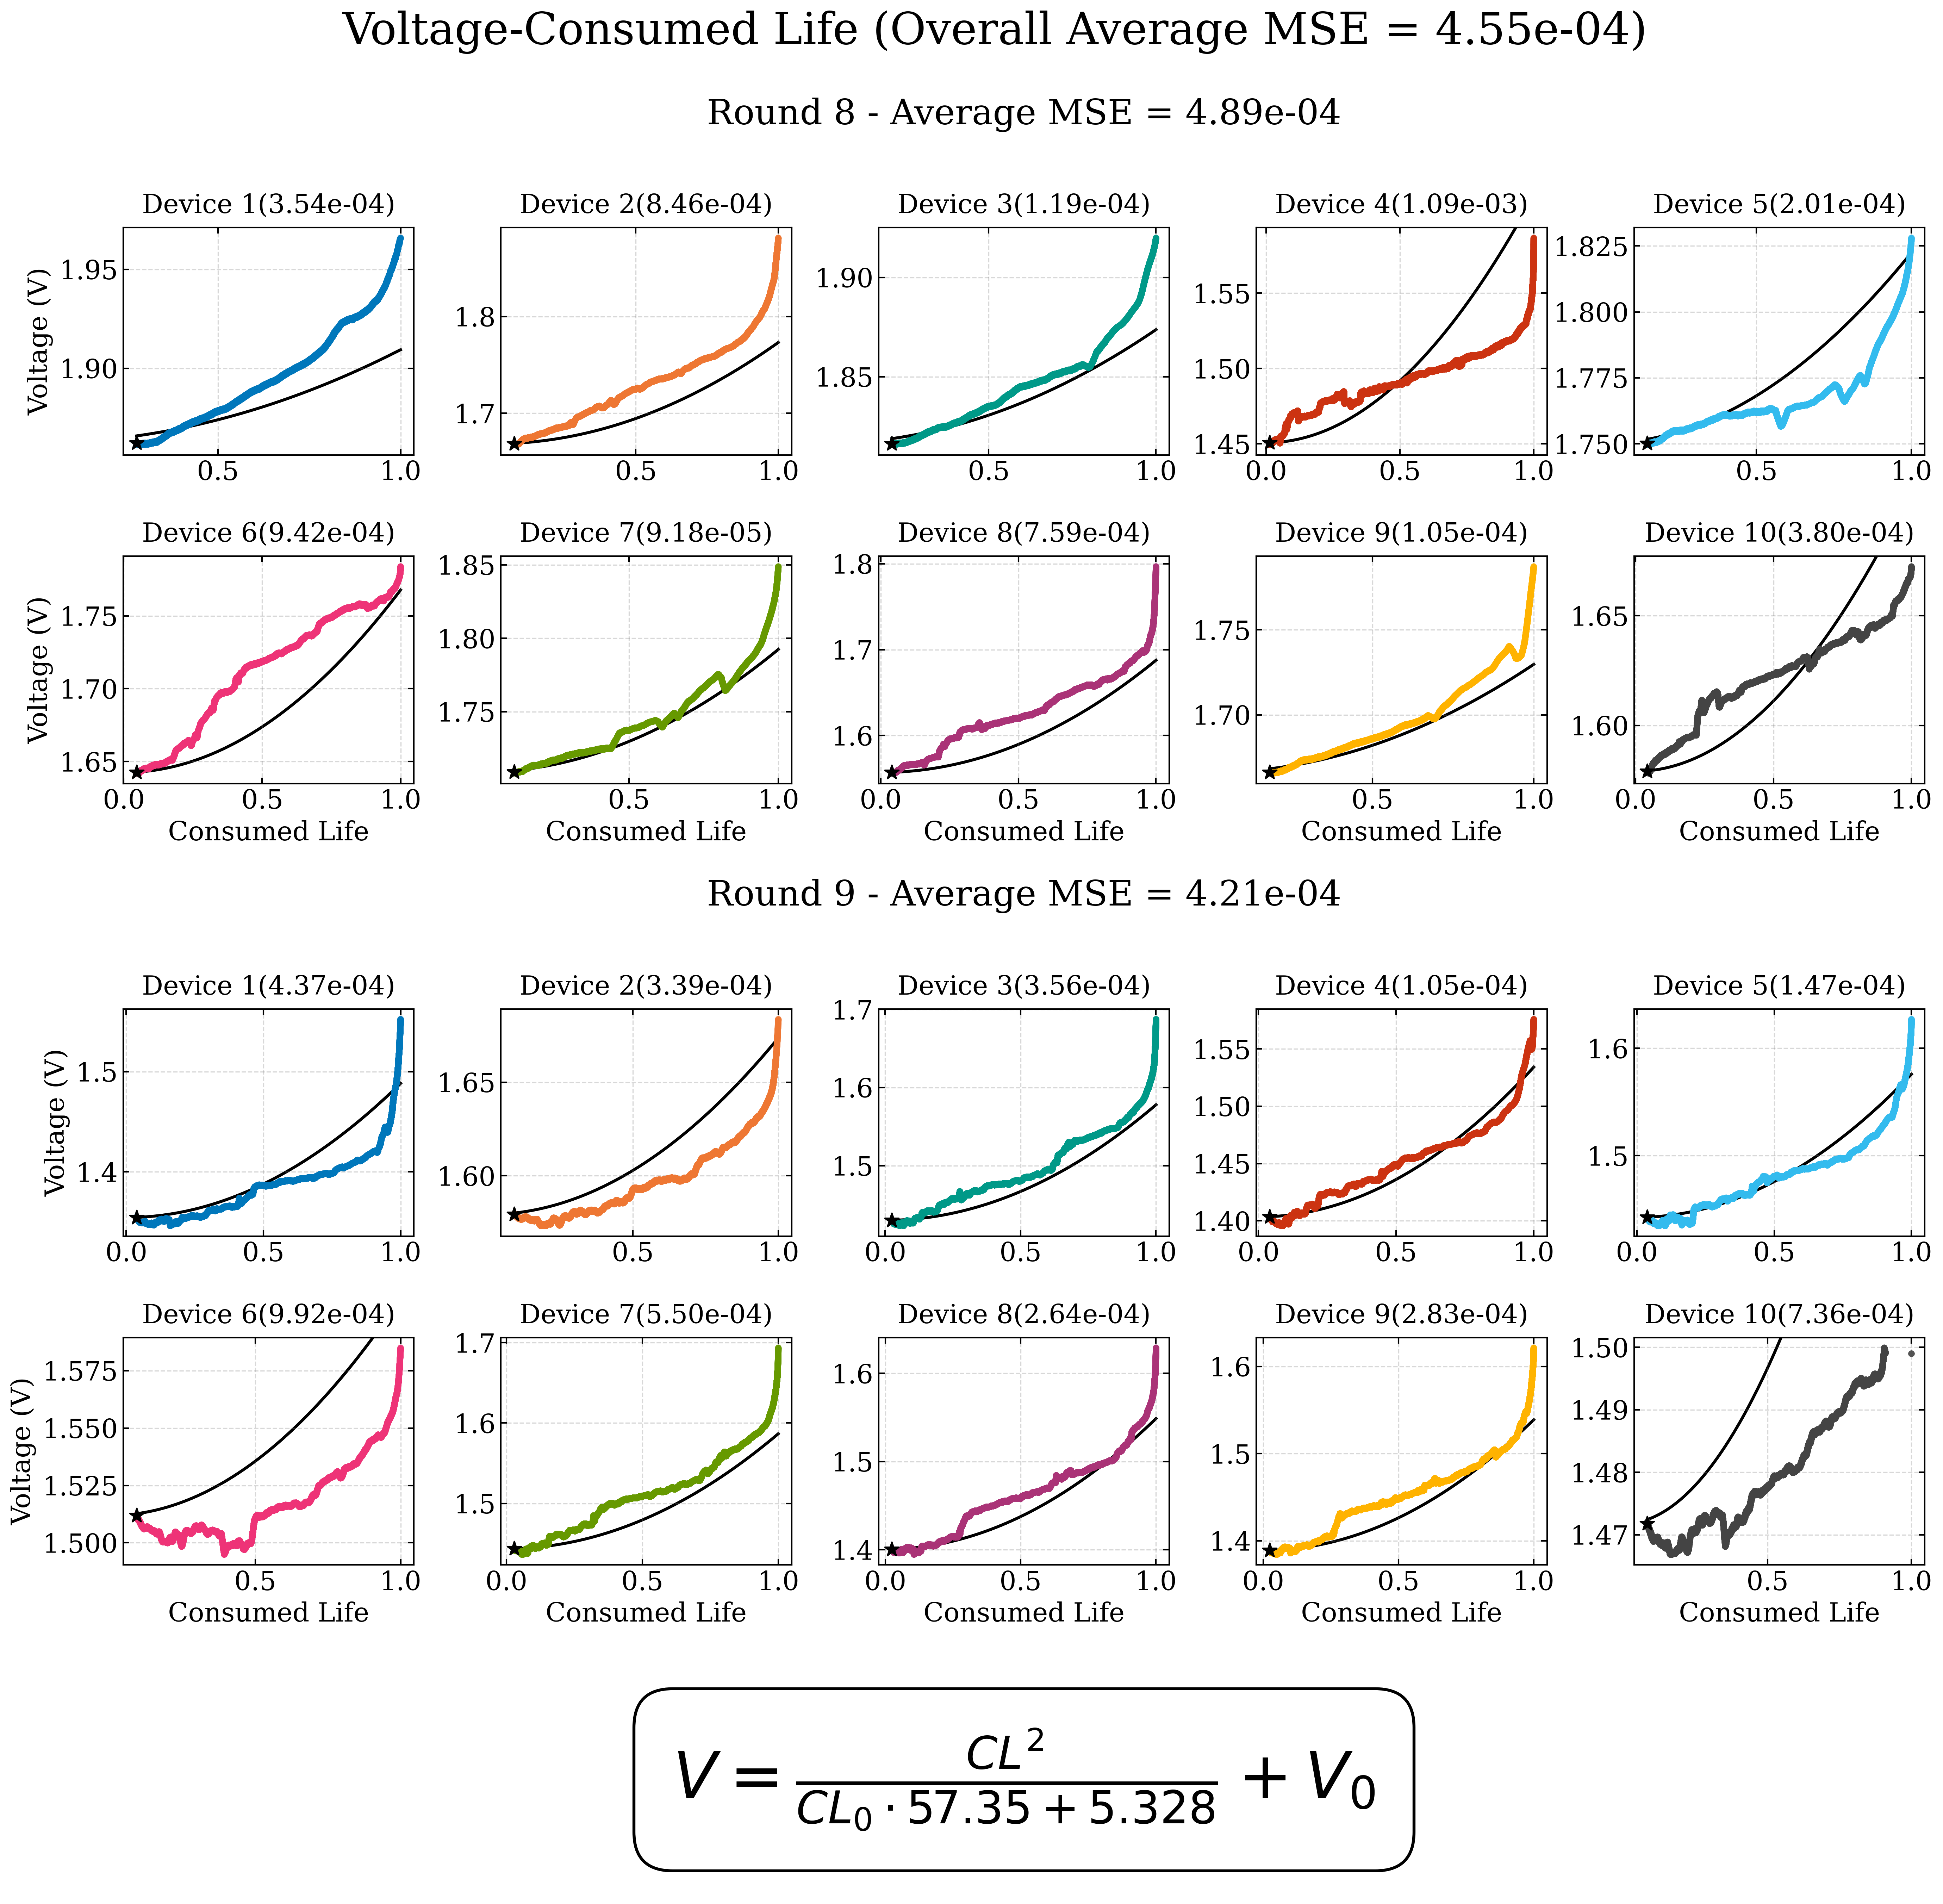

In [53]:
def combined_plot_data_comparison(X, y, model, eq_index=0, rounds=[8, 9], save_path=None):
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from matplotlib.lines import Line2D
    import pandas as pd
    import numpy as np
    from sklearn.metrics import mean_squared_error  # Added this import

    plt.style.use('default')
    mpl.rcParams.update({
        'font.family': 'serif',
        'font.size': 12,
        'axes.linewidth': 1.0,
        'axes.labelsize': 16,  # Increased font size for axis labels
        'axes.titlesize': 16,  # Increased font size for titles
        'xtick.major.width': 1.0,
        'ytick.major.width': 1.0,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.top': True,
        'ytick.right': True,
        'figure.dpi': 300
    })

    # Reduced figure height and adjusted GridSpec
    fig = plt.figure(figsize=(22, 22))
    gs = plt.GridSpec(7, 5, height_ratios=[0.1, 1, 1, 0.1, 1, 1, 1], 
                     hspace=0.6, wspace=0.3)

    colors = ['#0077BB', '#EE7733', '#009988', '#CC3311', '#33BBEE',
              '#EE3377', '#669900', '#AA3377', '#FFB300', '#444444']

    all_round_mses = []
    expr_latex = model.latex(eq_index, 4)

    for round_idx, round_number in enumerate(rounds):
        round_mask = X['round'] == round_number
        X_round = X[round_mask]
        y_round = y[round_mask]
        y_pred = model.predict(X_round, eq_index)

        device_mses = []

        for i in range(10):
            row_offset = 1 + round_idx * 3
            ax = fig.add_subplot(gs[row_offset + i // 5, i % 5])

            device_num = i + 1
            device_mask = X_round['device'] == device_num
            if not device_mask.any():
                ax.text(0.5, 0.5, 'No data available',
                        horizontalalignment='center',
                        verticalalignment='center',
                        transform=ax.transAxes,
                        fontsize=12)
                continue

            device_data = pd.DataFrame({
                'CL': X_round.loc[device_mask, 'CL'],
                'V': y_round[device_mask],
                'predicted_voltage': y_pred[device_mask],
                'V_0': X_round.loc[device_mask, 'V_0'],
                'CL_0': X_round.loc[device_mask, 'CL_0']
            }).sort_values('CL')

            if device_data.empty:
                continue

            # Corrected MSE calculation
            device_mse = mean_squared_error(device_data['V'], device_data['predicted_voltage'])
            device_mses.append(device_mse)
            v0 = device_data['V_0'].iloc[0]
            t0 = device_data['CL_0'].iloc[0]

            ax.scatter(device_data['CL'], device_data['V'],
                      label='Cleaned Data',
                      color=colors[i], alpha=0.7, s=20, marker='o',
                      zorder=2, edgecolors='none')

            ax.plot(device_data['CL'], device_data['predicted_voltage'],
                   linestyle='-', color='black', linewidth=2.0,
                   label='Model Prediction', zorder=1, alpha=1.0)

            ax.scatter(t0, v0, color='black', s=100, marker='*',
                      label='Initial State', zorder=3)

            # Increased spacing between titles and subplots
            ax.set_title(f'Device {device_num}({device_mse:.2e})', pad=10, fontsize=18)
            
            ax.grid(True, linestyle='--', alpha=0.3, color='gray')
            ax.tick_params(which='both', direction='in', top=True, right=True, length=4, labelsize=18)  # Increased font size for tick labels

            x_padding = (device_data['CL'].max() - device_data['CL'].min()) * 0.05
            y_padding = (device_data['V'].max() - device_data['V'].min()) * 0.05
            ax.set_xlim(device_data['CL'].min() - x_padding, device_data['CL'].max() + x_padding)
            ax.set_ylim(device_data['V'].min() - y_padding, device_data['V'].max() + y_padding)

            if i >= 5:
                ax.set_xlabel('Consumed Life', fontsize=18)  # Increased font size for x-axis label
            if i % 5 == 0:
                ax.set_ylabel('Voltage (V)', fontsize=18)  # Increased font size for y-axis label

        avg_mse = np.mean(device_mses) if device_mses else 0
        all_round_mses.append(avg_mse)

        # Compact round titles
        title_ax = fig.add_subplot(gs[row_offset - 1, :])
        title_ax.axis('off')
        title_ax.text(0.5, 0.5, f'Round {round_number} - Average MSE = {avg_mse:.2e}',
                     ha='center', va='center', fontsize=24,
                     transform=title_ax.transAxes)

    # Compact equation display
    ax_eq = fig.add_subplot(gs[6, :])
    ax_eq.axis('off')
    ax_eq.text(0.5, 0.5, f'$V = {expr_latex}$',
               ha='center', va='center', fontsize=44,
               transform=ax_eq.transAxes,
               bbox=dict(facecolor='white', edgecolor='black', 
                        linewidth=2, pad=15, boxstyle='round,pad=0.6'))

    overall_avg_mse = np.mean(all_round_mses) if all_round_mses else 0
    fig.suptitle(f'Voltage-Consumed Life (Overall Average MSE = {overall_avg_mse:.2e})',
                 fontsize=30, y=0.92)

    if save_path:
        # Save as PNG
        plt.savefig(save_path, bbox_inches='tight', dpi=300, 
                   facecolor='white', edgecolor='none')
    return fig, all_round_mses

# Example usage:
fig, avg_mses = combined_plot_data_comparison(X, y, model, eq_index=7, rounds=[8, 9],
                                            save_path='CL_vs_T_simple.png')
print(f"Average MSEs for each round: {avg_mses}")
